# **Setup**

In [60]:
import os
import numpy as np
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder
from xgboost import XGBClassifier

#**Get Dataset from Kaggle**

In [62]:
!pip install kaggle



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [63]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json  # Change file permissions
os.environ['KAGGLE_USERNAME'] = "virinchiv"
os.environ['KAGGLE_KEY'] = "0b9dd7658766f0ac5ebb17d0de3348b1"

In [64]:
!kaggle competitions download -c ieee-fraud-detection

ieee-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('ieee-fraud-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('ieee_fraud_data')

# List files to confirm extraction
os.listdir('ieee_fraud_data')

['test_transaction.csv',
 'train_identity.csv',
 'test_identity.csv',
 'sample_submission.csv',
 'train_transaction.csv']

#**Create Pandas DataFrame for Dataset**

In [67]:
# Load the dataset
train_transaction = pd.read_csv('ieee_fraud_data/train_transaction.csv')
train_identity = pd.read_csv('ieee_fraud_data/train_identity.csv')
test_transaction = pd.read_csv('ieee_fraud_data/test_transaction.csv')
test_identity = pd.read_csv('ieee_fraud_data/test_identity.csv')

In [68]:
# Display the first few rows
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Merge transaction and identity datasets on 'TransactionID'
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train_df.head()

# test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
# test_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


#**Handling Duplicates and Null Values**

In [72]:
# Remove null values from all columns except 'Time'
# train_df = train_df[train_df.columns.difference(['Time'])].dropna().join(train_df['Time'])

# Confirm the result
print("Remaining null values in the dataset:")
print(train_df.isnull().sum())

Remaining null values in the dataset:
TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64


In [73]:
train_df.duplicated().sum() #

0

In [74]:
threshold = 0.8
train_df = train_df[train_df.columns[train_df.isnull().mean() < threshold]]
train_df.head()

test_df = test_df[test_df.columns[test_df.isnull().mean() < threshold]]
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-20,id-28,id-29,id-31,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
for col in train_df.columns:
    if train_df[col].dtype in ['float64', 'int64']:
        train_df[col].fillna(train_df[col].median(), inplace=True)
    else:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)

# Drop columns that are irrelevant or have high cardinality (e.g., TransactionID, DeviceInfo)
irrelevant_cols = ['TransactionID', 'DeviceInfo']
train_df = train_df.drop(columns=irrelevant_cols)

for col in test_df.columns:
    if test_df[col].dtype in ['float64', 'int64']:
        test_df[col].fillna(test_df[col].median(), inplace=True)
    else:
        test_df[col].fillna(test_df[col].mode()[0], inplace=True)

# Drop columns that are irrelevant or have high cardinality (e.g., TransactionID, DeviceInfo)
test_df = test_df.drop(columns=irrelevant_cols)

/var/folders/yl/19nbcjt104gdn52x50k4b_sm0000gn/T/ipykernel_82016/4151065301.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
/var/folders/yl/19nbcjt104gdn52x50k4b_sm0000gn/T/ipykernel_82016/4151065301.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

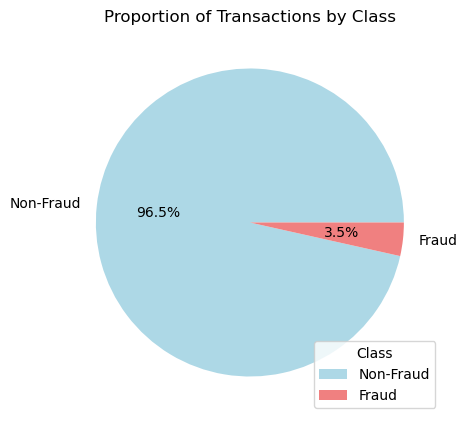

In [76]:
# Create a pie chart
class_counts = train_df['isFraud'].value_counts()

plt.figure(figsize=(8, 5))
plt.pie(class_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Transactions by Class')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='lower right')
plt.show()

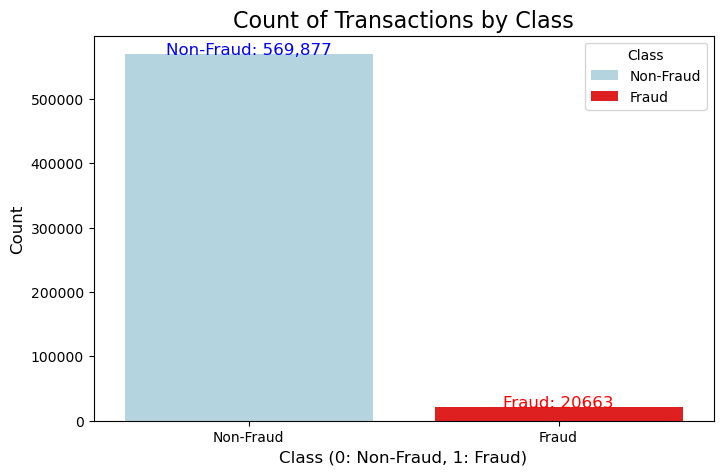

In [77]:
class_palette = {0: 'lightblue', 1: 'red'}

# Count plot for transactions
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='isFraud', data=train_df, hue='isFraud', palette=class_palette, order=train_df['isFraud'].value_counts().index)

# Get the counts for non-fraud and fraud
non_fraud_count = train_df['isFraud'].value_counts()[0]
fraud_count = train_df['isFraud'].value_counts()[1]

# Adding text annotations for counts with comma formatting
plt.text(0, non_fraud_count + 50, f'Non-Fraud: {non_fraud_count:,}', color='blue', fontsize=12, ha='center')
plt.text(1, fraud_count + 50, f'Fraud: {fraud_count}', color='red', fontsize=12, ha='center')

plt.title('Count of Transactions by Class', fontsize=16)
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='upper right')
plt.show()

In [78]:
# Convert categorical variables to dummy variables
train_df = pd.get_dummies(train_df, drop_first=True)

# Scale the data (important for neural networks)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df.drop(columns=['isFraud']))
scaled_df = pd.DataFrame(scaled_data, columns=train_df.drop(columns=['isFraud']).columns)

# Add back the target variable 'isFraud'
scaled_df['isFraud'] = train_df['isFraud'].values

In [79]:
# test_df = test_df.reindex(columns=train_df.columns, fill_value=0)
# # test_df = pd.get_dummies(test_df, drop_first=True)
# scaled_test_data = scaler.fit_transform(test_df)  # Exclude the target variable
# scaled_test_df = pd.DataFrame(scaled_test_data, columns=test_df.columns)

# **Split Data**

In [81]:
X = scaled_df.drop(columns=['isFraud'])  # Features
y = scaled_df['isFraud']                 # Target

# Perform a stratified train-test split to ensure proportional distribution of fraud cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [82]:
# Scaled data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **AutoEncoder Neural Network**


In [84]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class AutoEncoder(Model):
  def __init__(self):
        encoding_dim = 64
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            Dense(encoding_dim, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(int(encoding_dim/2), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(int(encoding_dim/4), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.5),
            Dense(int(encoding_dim/8), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Dense(int(encoding_dim/4), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(int(encoding_dim/2), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(encoding_dim, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(X_train.shape[1], activation='sigmoid'),
        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [85]:
# Autoencoder model
model = AutoEncoder()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the Autoencoder
history = model.fit(X_train_scaled, X_train_scaled, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=(X_test_scaled, X_test_scaled),
                          callbacks = [early_stopping, lr_schedule])

Epoch 1/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0200 - val_loss: 0.9900 - learning_rate: 0.0010
Epoch 2/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9232 - val_loss: 0.9848 - learning_rate: 0.0010
Epoch 3/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9168 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 4/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9123 - val_loss: 0.9809 - learning_rate: 0.0010
Epoch 5/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9034 - val_loss: 0.9794 - learning_rate: 0.0010
Epoch 6/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8833 - val_loss: 0.9786 - learning_rate: 0.0010
Epoch 7/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9071 - val_loss: 0.9778 - learning_rate: 0.0010
Epoch 8/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8917 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 9/50
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9009 - val_loss: 0.9769 - learning_rate:

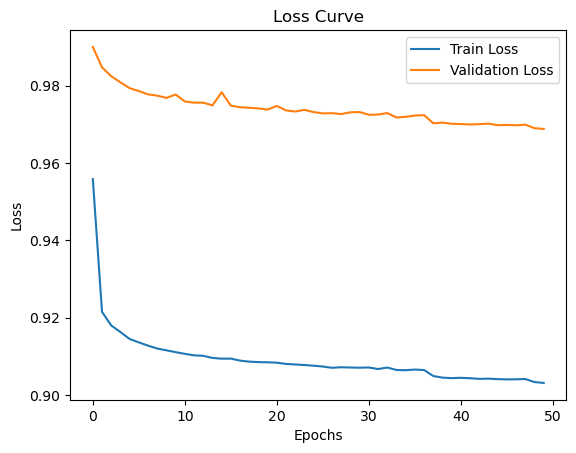

In [86]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
# Get reconstruction errors for the test data (normal and fraud)
reconstructions = model.predict(X_test_scaled) #using test data
reconstruction_error = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1) #using test data
reconstruction_error

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step


array([0.13072119, 0.30414211, 0.20616182, ..., 0.06666274, 0.12065589,
       0.13962195])

In [88]:
threshold = np.percentile(reconstruction_error, 90)
threshold

1.0716081935303827

In [95]:
# Predict fraud based on reconstruction error
y_pred_autoencoder = [1 if e > threshold else 0 for e in reconstruction_error]

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_autoencoder)
# Actual labels (fraud is 1, non-fraud is 0)
# y_true = [1]*len(fraud) + [0]*len(X_test)

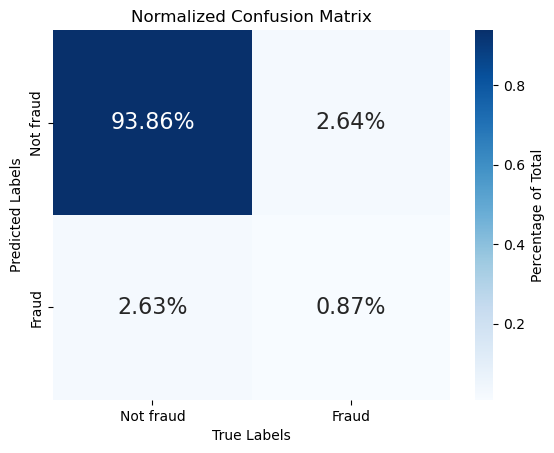

              precision    recall  f1-score   support

           0       0.98      0.91      0.94    113975
           1       0.13      0.36      0.19      4133

    accuracy                           0.89    118108
   macro avg       0.55      0.64      0.57    118108
weighted avg       0.95      0.89      0.91    118108



In [139]:
# Confusion Matrix and Classification Report
categories = ['Not fraud', 'Fraud']
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix),  # Normalized by the total sum for percentages
    annot=True,  # Show the annotations
    annot_kws={'size': 16},  # Size of annotations
    cmap='Blues',  # Color map
    fmt='.2%',  # Format the annotation to show percentage
    xticklabels=categories,  # Set x-axis labels
    yticklabels=categories,  # Set y-axis labels
    cbar_kws={'label': 'Percentage of Total'}  # Add color bar with label
)

plt.ylabel('Predicted Labels')  # X-axis label
plt.xlabel('True Labels')  # Y-axis label
plt.title('Normalized Confusion Matrix')  # Title of the plot
plt.show()
print(classification_report(y_test, y_pred_autoencoder))

# **ISOLATION FOREST MODEL**

In [131]:
# outlier fraction to get contamination rate for isolation forest
outlier_fraction = y_test.mean()
print(f"Outlier Fraction in Test Set: {outlier_fraction:.4f}")

Outlier Fraction in Test Set: 0.0350


Isolation Forest Model Performance:


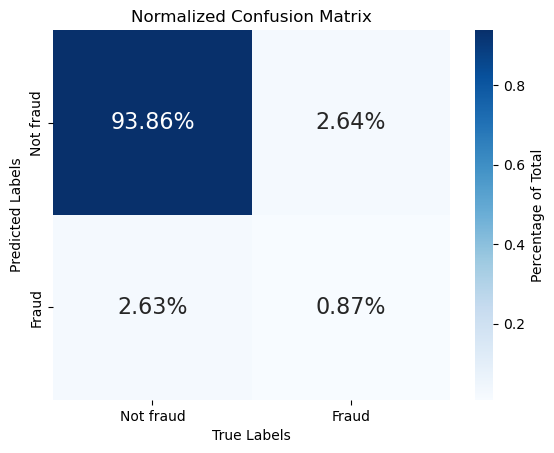

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    113975
           1       0.25      0.25      0.25      4133

    accuracy                           0.95    118108
   macro avg       0.61      0.61      0.61    118108
weighted avg       0.95      0.95      0.95    118108



In [137]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, accuracy_score

# Best parameters from the grid search
isolation_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=.035, random_state=42)

# Train the best Isolation Forest model on the same train data
isolation_forest.fit(X_train)

# Predict the labels on the same test set
y_pred_isoforest = isolation_forest.predict(X_test)
y_pred_isoforest = np.where(y_pred_isoforest == -1, 1, 0)  # Convert to 1 for fraud, 0 for non-fraud

# Evaluate Isolation Forest
print("Isolation Forest Model Performance:")
confusion_matrix_2 = sklearn.metrics.confusion_matrix(y_test, y_pred_isoforest)
sns.heatmap(
    confusion_matrix_2 / np.sum(confusion_matrix_2),  # Normalized by the total sum for percentages
    annot=True,  # Show the annotations
    annot_kws={'size': 16},  # Size of annotations
    cmap='Blues',  # Color map
    fmt='.2%',  # Format the annotation to show percentage
    xticklabels=categories,  # Set x-axis labels
    yticklabels=categories,  # Set y-axis labels
    cbar_kws={'label': 'Percentage of Total'}  # Add color bar with label
)
plt.ylabel('Predicted Labels')  # X-axis label
plt.xlabel('True Labels')  # Y-axis label
plt.title('Normalized Confusion Matrix')  # Title of the plot
plt.show()
print(classification_report(y_test, y_pred_isoforest))

In [135]:
# -------------------
# Compare Results
# -------------------
# AutoEncoder evaluation metrics
precision_auto, recall_auto, fscore_auto, _ = precision_recall_fscore_support(y_test, y_pred_autoencoder, average='binary')
roc_auc_auto = roc_auc_score(y_test, y_pred_autoencoder)
accuracy_auto = accuracy_score(y_test, y_pred_autoencoder)

# Isolation Forest evaluation metrics
precision_iso, recall_iso, fscore_iso, _ = precision_recall_fscore_support(y_test, y_pred_isoforest, average='binary')
roc_auc_iso = roc_auc_score(y_test, y_pred_isoforest)
accuracy_iso = accuracy_score(y_test, y_pred_isoforest)

# Print comparison
print("\n--- Models Comparison ---")
print(f"AutoEncoder - Precision (Fraud): {precision_auto:.2f}, Recall: {recall_auto:.2f}, F1 Score: {fscore_auto:.2f}, ROC AUC: {roc_auc_auto:.2f}, Accuracy: {accuracy_auto:.4f}")
print(f"Isolation Forest - Precision (Fraud): {precision_iso:.2f}, Recall: {recall_iso:.2f}, F1 Score: {fscore_iso:.2f}, ROC AUC: {roc_auc_iso:.2f}, Accuracy: {accuracy_iso:.4f}")


--- Models Comparison ---
AutoEncoder - Precision (Fraud): 0.13, Recall: 0.36, F1 Score: 0.19, ROC AUC: 0.64, Accuracy: 0.8905
Isolation Forest - Precision (Fraud): 0.25, Recall: 0.25, F1 Score: 0.25, ROC AUC: 0.61, Accuracy: 0.9474
